In [2]:
from interferometer import Interferometer
from scipy.interpolate import interp1d
import numpy as np
import jax.numpy as jnp
import gw
from matplotlib import pyplot as pl
import corner
import pickle
%matplotlib inline

In [3]:
f_min = 20. #minimum frequency cut-off
T = 8.  #data segment duration (8 seconds)
Fs = 2048 #samplingfrequency  (Hz)
#t_start = 1126259446. #strain data segment start time 
t_start=0.
# since signals are generated in frequency domain this time is only used for calculating time dealys and hence is set to t_coalsecence

#initialise the detectors
H1 = Interferometer('H1','O3',f_min,T,Fs,t_start,20011997)
L1 = Interferometer('L1','O3',f_min,T,Fs,t_start,27071994)

detectors = [H1, L1]

In [4]:
t=H1.times #time array for the time domain signal
A=10
t0=4
f0=4
tau=4./f0


In [5]:
def simulate_fd_sine_gaussian_waveform(A, t0, f0, tau, times, fmin, df):   #without phase for now
    
    t = times
    
    hpt = A * np.exp(-(t-t0)**2/tau**2)*np.cos(2*np.pi*f0*t) #time domain plus polarisation
    hct = A * np.exp(-(t-t0)**2/tau**2)*np.sin(2*np.pi*f0*t) #time domain cross polarisation

    hp = np.fft.rfft(hpt) #frequency domain plus polarisation
    hc = np.fft.rfft(hct) #frequency domain cross polarisation

    #recreate frequency array
    freqs= df * np.arange(len(hp)) 
    start = int(fmin/df) #index of the first non-zero value of the fd signal (corresponding to f_min)
                          
    return hp[start:], hc[start:], freqs[start:]

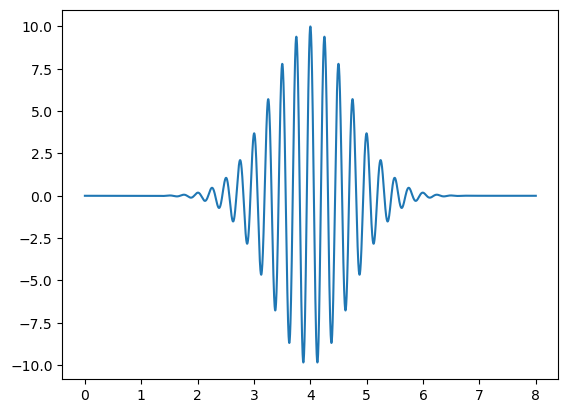

In [6]:
#simulate signal 
hp, hc, freqs = simulate_fd_sine_gaussian_waveform(A,t0,f0,tau,t,0.,H1.df)
hpt = np.fft.irfft(hp)
pl.plot(t,hpt)

In [7]:
#sort the weird thing

def model(theta, detectors):
    
    #create an array to hold the frequency series of the data 
    
    ffreqs = detectors[0].get_frequency_array()     #get frequency array in the detector (should be same for both)
    times = detectors[0].times
    N = len(freqs)
    f_min = freqs[0] 
    df = freqs[1]-freqs[0]
    
    signal = np.zeros(N)
    signal = signal + 0j
    
    signals = {det.name: signal for det in detectors}   #dictionary to hold model signals
    
    A, t0, f0, tau, ra, dec, psi = theta
    
    hp, hc, _ = simulate_fd_sine_gaussian_waveform(A, t0, f0, tau, times, f_min, df)

    for det in detectors:

        #apply antenna response of the detector
    
        fp, fc = det.get_antenna_response_jax(ra, dec, psi, t0)
        hf = hp*fp + hc*fc

        signals[det.name] = hf
            
        #apply delay (following bilby interferometer.p, line 316-322)
        dt_geoct = t0 - det.t_start   #geocentic time of arrival - time segment start time   (time delay at geocenter, 0 for t0_true) 
        dt_delay = det.get_time_delay_jax(ra, dec, t0)  #travel time between geocenter & detector
        tau_delay = dt_geoct + dt_delay

        signals[det.name] *= jnp.exp(-2*jnp.pi*1j*freqs*tau_delay)   # cexp = jnp.exp(-1j*2*jnp.pi*freqs*deltat)
    
    return signals

In [8]:
A=10.
t0=4.
f0=4.
tau=4./f0
ra=1.5
dec=0.5
psi=1.0

truths = [A, t0, f0, tau, ra, dec, psi]

hfs = model(truths, detectors) #get model & apply detector response & delays

#inject signals into detectors
for det in detectors:
    det.strain = hfs[det.name]

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [9]:
L1.strain

Array([-1.0495475e-05+0.0000000e+00j,  1.0505873e-05+1.8605441e-06j,
       -1.0537150e-05-3.7376506e-06j, ...,  3.0011843e-10-3.1060288e-10j,
       -3.0312164e-10+3.0787331e-10j,  3.0493483e-10-3.0570652e-10j],      dtype=complex64)

In [10]:
#set noise to constant variance of 1 in each freq bin
H1.psd = 1.
L1.psd = 1.

In [15]:
class Network(object):
    """Class for the Interferometer Network """

    def __init__(self, detectors):
        """
        Instantiate an Interferometer object.

        Parameters
        ----------
        name: str
            Interferometer name, e.g., 'H1'.
        sensitivity: str
            Detector sensitivity, e.g. 'O1'
        minimum_frequency: float
            Minimum frequency to analyse for detector.
        """
        self.detectors = detectors
    
    def network_loglikelihood(self, model):
        """ calculates loglikelihood
        """    
        return sum([det.loglikelihood(model[det.name]) for det in self.detectors])

In [16]:
#initialise the detector network
detectors = [H1,L1]
network=Network(detectors)
network.network_loglikelihood(hfs)

0.0

In [17]:
#define the loglikelihood
def logL(theta):
    f0=4
    tau=4./f0
    t0 = 4
    A, ra, dec, psi = theta
    hfs = model(truths, detectors) #get model & apply detector response & delays

    model_signal = model([A, t0, f0, tau, ra, dec, psi], detectors)
    
    return network.network_loglikelihood(model_signal)

In [20]:
theta = [10.,1.5,0.5,1.0]
logL(theta)

0.0

In [21]:
import numpy as np
import jax
import jax.numpy as jnp

import optax
import corner
import matplotlib.pyplot as plt

from functools import partial
import jimgw

import distrax
import haiku as hk     #
from typing import Any, Iterator, Mapping, Optional, Sequence, Tuple   #

from vi_routines import make_flow_model

Array = jnp.ndarray
PRNGKey = Array
OptState = Any

In [22]:
#@jax.jit

# likelihood function
class LogL(object):
    
    def __call__(self, gw_params):
        theta = [gw_params['A'], gw_params['ra'], gw_params['dec'], gw_params['psi']]
        return logL(theta)
    
    #@property
   # def gw_params(self):
       # gw_params = ['A','B','C']
        #return gw_params

    def array_to_phys(self, x: Array) -> dict:           #transformation from the domain of the flow to 
        p = dict()
        p['A']=(x[0]+1)*5  #0 to 10                       
        #p['t0']=(x[1]+1)*4  #0 to 8
        p['ra']=x[1]+1      #0 to 2
        p['dec']=x[2]+1     #0 to 2
        p['psi']=x[3]+1     #0 to 2

        return p

In [23]:
#Neural network setup

@hk.without_apply_rng
@hk.transform
def sample_and_log_prob(prng_key: PRNGKey, n: int) -> Tuple[Any, Array]:

    model = make_flow_model(                          #this is the flow distribution (a distrax object)
        event_shape=(n_params,),
        num_layers=flow_num_layers,
        hidden_sizes=[hidden_size] * mlp_num_layers,
        num_bins=num_bins
    )

    return model.sample_and_log_prob(seed=prng_key, sample_shape=(n,))
     # returns x (sample from the flow q), and model.log_prob(x) (array of log(q) of th sampled points)


def log_likelihood(x: Array) -> Array:      #transform to parameter space before c
    p = log_l.array_to_phys(x)
    return log_l(p)

def loss_fn(params: hk.Params, prng_key: PRNGKey, n: int) -> Array:       #computes reverse KL-divergence for the sample x_flow between the flow and gw loglikelihood.

    x_flow, log_q = sample_and_log_prob.apply(params, prng_key, n)           #gets sample from the flow and computes log_q for the sampled points.
    log_p = jnp.array([log_likelihood(x) for x in x_flow])
                                           #gets gw loglikelihood for the sampled points (after transforming them into physical space..)
    loss = jnp.mean(log_q - log_p)
    return loss

@jax.jit
def update(
    params: hk.Params,
    prng_key: PRNGKey,
    opt_state: OptState,
) -> Tuple[hk.Params, OptState]:
    """Single SGD update step."""
    grads = jax.grad(loss_fn)(params, prng_key, Nsamps)
    updates, new_opt_state = optimiser.update(grads, opt_state)
    new_params = optax.apply_updates(params, updates)
    return new_params, new_opt_state


In [25]:

n_params = 4
flow_num_layers = 4
hidden_size = 16
mlp_num_layers = 2
num_bins = 4


# perform variational inference
epochs = 100
loss = dict(train=[], val=[])
Nsamps = 100

learning_rate = 0.01
optimiser = optax.adam(learning_rate)              #stochastic gradient descent 

prng_seq = hk.PRNGSequence(42)
key = next(prng_seq)
params = sample_and_log_prob.init(key, prng_key=key, n=Nsamps)
opt_state = optimiser.init(params)

from tqdm import tqdm, trange
   
ldict = dict(loss = 0, T=1)

log_l = LogL()         

with trange(epochs) as tepochs:
    for epoch in tepochs:
  
        #update NN params (stochastic gradient descent with Adam optimiser)
        prng_key = next(prng_seq)
        loss = loss_fn(params,  prng_key, Nsamps)
        ldict['loss'] = f'{loss:.2f}'
        tepochs.set_postfix(ldict, refresh=True)
        params, opt_state = update(params, prng_key, opt_state)        #take a step in direction of stepest descent (negative gradient)
            
            
        #print results every 50 iterations
        if epoch%50 == 0:
            print(f'Epoch {epoch}, loss {loss}')
            x_gen, log_prob_gen = sample_and_log_prob.apply(params, next(prng_seq), 10*Nsamps)
            x_gen = np.array(x_gen, copy=False)
            p_gen = np.vstack(list(log_l.array_to_phys(x_gen).values()))
            truths = [log_l.true_gw_params[n] for n in ['A','B','C']]
            fig = corner.corner(p_gen.T, labels = log_l.gw_params, truths = truths)
            plt.show()

print("Done!")

x_gen, log_prob_gen = sample_and_log_prob.apply(params, next(prng_seq), 100*Nsamps)

x_gen = np.array(x_gen, copy=False)
p_gen = np.vstack(list(log_l.array_to_phys(x_gen).values()))
truths = [log_l.true_gw_params[n] for n in ['A','B','C']]
fig = corner.corner(p_gen.T, labels = log_l.gw_params, truths = truths)
plt.show()

  0%|          | 0/100 [00:05<?, ?it/s, loss=232234832.00, T=1]


TracerArrayConversionError: The numpy.ndarray conversion method __array__() was called on the JAX Tracer object Traced<ShapedArray(float32[16384])>with<JVPTrace(level=2/1)> with
  primal = Traced<ShapedArray(float32[16384])>with<DynamicJaxprTrace(level=0/1)>
  tangent = Traced<ShapedArray(float32[16384])>with<JaxprTrace(level=1/1)> with
    pval = (ShapedArray(float32[16384]), None)
    recipe = JaxprEqnRecipe(eqn_id=<object object at 0x7fa0a45ea750>, in_tracers=(Traced<ConcreteArray([1.         0.9999247  0.99969882 ... 0.99932238 0.99969882 0.9999247 ], dtype=float32):JaxprTrace(level=1/1)>, Traced<ShapedArray(float32[16384]):JaxprTrace(level=1/1)>), out_tracer_refs=[<weakref at 0x7fa0a4390950; to 'JaxprTracer' at 0x7fa0a4390630>], out_avals=[ShapedArray(float32[16384])], primitive=xla_call, params={'device': None, 'backend': None, 'name': 'fn', 'donated_invars': (False, False), 'inline': True, 'keep_unused': False, 'call_jaxpr': { [34m[22m[1mlambda [39m[22m[22m; a[35m:f32[16384][39m b[35m:f32[16384][39m. [34m[22m[1mlet[39m[22m[22m c[35m:f32[16384][39m = mul b a [34m[22m[1min [39m[22m[22m(c,) }}, effects=set(), source_info=SourceInfo(traceback=<jaxlib.xla_extension.Traceback object at 0x7fa0a43953b0>, name_stack=NameStack(stack=(Transform(name='jvp'),))))
See https://jax.readthedocs.io/en/latest/errors.html#jax.errors.TracerArrayConversionError

In [ ]:
jax.grad(logL)([0.,0.,0.,0.])

TracerArrayConversionError: The numpy.ndarray conversion method __array__() was called on the JAX Tracer object Traced<ConcreteArray([0. 0. 0. ... 0. 0. 0.], dtype=float32)>with<JVPTrace(level=2/0)> with
  primal = Array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)
  tangent = Traced<ShapedArray(float32[16384])>with<JaxprTrace(level=1/0)> with
    pval = (ShapedArray(float32[16384]), None)
    recipe = JaxprEqnRecipe(eqn_id=<object object at 0x7f607436d2f0>, in_tracers=(Traced<ConcreteArray([1.         0.9999247  0.99969882 ... 0.99932238 0.99969882 0.9999247 ], dtype=float32):JaxprTrace(level=1/0)>, Traced<ShapedArray(float32[16384]):JaxprTrace(level=1/0)>), out_tracer_refs=[<weakref at 0x7f6074361120; to 'JaxprTracer' at 0x7f6074362390>], out_avals=[ShapedArray(float32[16384])], primitive=xla_call, params={'device': None, 'backend': None, 'name': 'fn', 'donated_invars': (False, False), 'inline': True, 'keep_unused': False, 'call_jaxpr': { [34m[22m[1mlambda [39m[22m[22m; a[35m:f32[16384][39m b[35m:f32[16384][39m. [34m[22m[1mlet[39m[22m[22m c[35m:f32[16384][39m = mul b a [34m[22m[1min [39m[22m[22m(c,) }}, effects=set(), source_info=SourceInfo(traceback=<jaxlib.xla_extension.Traceback object at 0x7f60743de0f0>, name_stack=NameStack(stack=(Transform(name='jvp'),))))
See https://jax.readthedocs.io/en/latest/errors.html#jax.errors.TracerArrayConversionError

In [ ]:
truths

[10, 4, 4, 1.0, 1.5, 0.5, 1.0]

In [ ]:
x_gen, log_prob_gen = sample_and_log_prob.apply(params, next(prng_seq), 10*Nsamps)

In [ ]:
x_gen[:2,:]
logL([ 0.17288971, -0.6864164 , -0.78445077, -0.62187004])

-7.267221335031241e-16

In [ ]:
x_gen[:2,:]

Array([[ 0.17288971, -0.6864164 , -0.78445077, -0.62187004],
       [ 0.7480638 , -0.0611093 , -0.635396  , -0.5521736 ]],      dtype=float32)

In [ ]:
logL(x_gen[:1][0])

-5.468962594475922e-12

In [ ]:
x_gen[:1][0]

Array([ 0.17288971, -0.6864164 , -0.78445077, -0.62187004], dtype=float32)

In [ ]:
x_gen[:1]

Array([[ 0.17288971, -0.6864164 , -0.78445077, -0.62187004]], dtype=float32)

In [ ]:
[logL(theta) for theta in x_gen[]

SyntaxError: invalid syntax (1182874528.py, line 1)

In [ ]:
logL

In [ ]:
import jimgw
from jimgw.PE.detector_projection import make_detector_response
from jimgw.PE.detector_projection import make_antenna_response
from jimgw.PE.detector_preset import * 

In [ ]:
import lal


In [ ]:
H1_response = make_detector_response(H1.laldetector.response, H1.laldetector.location)   #detector_response(f, hp, hc, ra, dec, gmst, psi), strain in freq domain
gps = lal.LIGOTimeGPS(t0)
gmst_rad = lal.GreenwichMeanSiderealTime(gps)
antenna_response_plus = make_antenna_response(H1.laldetector.response, 'plus')
antenna_response_plus(ra, dec, gmst_rad, psi)

Array(-0.437629, dtype=float32)

In [ ]:
fp, fc = H1.get_antenna_response_jax(ra, dec, psi, t0)


